In [1]:
## Preprocessing pipeline for all tracks

## 1. median filter (3 frames)
## 2. interpolation (cubic)
## 3. Deal with longer tracks (unspecified -> might be random forest)
## 4. Egocentric
## 5. Normalization

import os
from rich.progress import track
from einops import rearrange
from tqdm import tqdm

import numpy as np

from scipy import ndimage
from scipy.interpolate import interp1d
from skimage.measure import label

import seaborn as sns
import matplotlib.pyplot as plt

from typing import List, Optional, Tuple

joint_list = np.array([
    "Nose", "Head", "Left Ear",
    "Right Ear", "Trunk", "Tail Base",
    "Tail_tip", "t0", "t1", "t2",
    "neck", "Left Hpaw", "Right Hpaw",
    "Left Fpaw", "Right Fpaw"
])

omit_joints_idx = np.array([
    np.where(joint_list == "Tail_tip")[0][0],
    np.where(joint_list == "t0")[0][0],
    np.where(joint_list == "t1")[0][0],
    np.where(joint_list == "t2")[0][0]
])

joints_idx = np.array([i for i in range(len(joint_list)) if i not in omit_joints_idx])

In [2]:
data_path = "/scratch/gpfs/tt1131/rotation_project_spring/track_evaluation/data/"
condition_list = ["sham_gdx", "testosterone", "gdx", "intact"]
sample_dict = np.load(
    os.path.join(data_path, f"{condition_list[-1]}_track_dict_abrv.npy"),
    allow_pickle=True,
).item()

track_occupancy_list = []
locations_list = []
joint_scores_list = []

## Sorting different data into tracks, also get rid of some of the tails tracking
for dict_key in sample_dict.keys():
    t_o = sample_dict[dict_key][3]
    loc = sample_dict[dict_key][4][:, joints_idx, :, :]
    js = sample_dict[dict_key][5][:, joints_idx, :]
    track_occupancy_list.append(t_o)
    joint_scores_list.append(js)
    locations_list.append(loc)

In [3]:
def median_filter(data: np.ndarray, kernel_size: int = 3) -> np.ndarray:
    """
    Applies a median filter on a dataset with dimensions (T, F)
    
    Args:
        data (ndarray): Input data with dimensions (T, F)
        kernel_size (int): Size of the median filter kernel. Default is 3.
    
    Returns:
        filtered_data (ndarray): Output data with dimensions (T, F)
    """
    
    # Reshape input data to (T, F, 1)
    data = data[..., np.newaxis]
    
    # Apply median filter along the time dimension
    filtered_data = ndimage.median_filter(data, size=(kernel_size, 1, 1))
    # Reshape output data to (T, F)
    filtered_data = filtered_data[..., 0]
    
    return filtered_data

median_filter_locations = []

for indv_ts, indv_js in zip(locations_list, joint_scores_list):
    m1 = median_filter(rearrange(indv_ts[..., 0], "T F D -> T (F D)"))
    m2 = median_filter(rearrange(indv_ts[..., 1], "T F D -> T (F D)"))

    median_filter_locations.append(np.stack([m1, m2], axis=-1))

In [4]:
def identify_continuous_nans(arr: np.ndarray, max_gap: Optional[int] = None) -> List[Tuple[int, int]]:
    """
    Identify continuous NaN regions in a 1D NumPy array.

    Args:
        arr (np.ndarray): Input 1D array.
        max_gap (Optional[int], optional): Maximum gap size allowed between two NaN values for them to be
            considered part of the same continuous NaN region. If None (default), all NaN regions are returned.

    Returns
        List[Tuple[int, int]]: List of (start_index, end_index) tuples for each continuous NaN
            region that meets the max_gap criterion. The start_index and
            end_index are the indices in the input array where the NaN
            region starts and ends, respectively.
    """
    # Create a binary mask where NaN values are True
    mask = np.isnan(arr)

    # Label the connected regions of True values in the mask
    labels = label(mask)

    # Loop over each NaN region and record its start and end indices
    nan_regions = []
    for region_label in np.unique(labels[labels > 0]):
        region_mask = labels == region_label
        start_index = np.argmax(region_mask)
        end_index = len(region_mask) - np.argmax(np.flip(region_mask))
        region_length = end_index - start_index
        if max_gap is None or region_length <= max_gap:
            nan_regions.append((start_index, end_index))

    return nan_regions

def interpolate_small_regions(arr: np.ndarray, max_gap: Optional[int] = None, 
                              kind: str = 'cubic', region_size: int = 120) -> np.ndarray:
    """
    Interpolate NaN values in a 1D NumPy array by using cubic interpolation on small NaN regions.

    Args:
        arr (np.ndarray): Input 1D array with NaN values to interpolate.
        max_gap (Optional[int], optional): Maximum gap size allowed between two NaN values for them to be
            considered part of the same continuous NaN region. If None
            (default), all NaN regions are returned.
        kind (str, optional): Type of interpolation to use. Default is 'cubic'. 
            Other options are 'linear', 'nearest', and 'quadratic'.
        region_size (int, optional): Size of the region to use for interpolation. Default is 120.

    Returns
        np.ndarray: 1D array with NaN values interpolated.
    """
    nan_regions = identify_continuous_nans(arr, max_gap)
    region_half = region_size // 2
    interp_arr = np.copy(arr)

    for start, end in nan_regions:
        # Pad data with 60 frames before and after NaN region
        start_pad = max(0, start - region_half) 
        end_pad = min(len(arr), end + region_half)
        
        non_nan_indices_l = np.argwhere(~np.isnan(arr[start_pad: start])).flatten() + start_pad
        non_nan_indices_r = np.argwhere(~np.isnan(arr[end: end_pad])).flatten() + end
        
        indices = np.concatenate([non_nan_indices_l, non_nan_indices_r])
        if len(indices) >= 4: ## Ensure enough points for interpolation
            interp_func = interp1d(indices, arr[indices], kind = kind, fill_value = 'extrapolate')
            interp_arr[start: end] = interp_func(np.arange(start, end))
        assert np.all(~np.isnan(interp_arr[start: end].shape))
        
    return interp_arr


def interpolate_features_small_regions(arr: np.ndarray, max_gap: Optional[int] = None, 
                        kind: str = 'cubic', region_size: int = 120) -> np.ndarray:
    """
    Interpolate NaN values in a 2D NumPy array by using cubic interpolation on small NaN regions.

    Args:
        arr (np.ndarray): Input 2D array of (Time X Features) with NaN values to interpolate.
        max_gap (Optional[int], optional): Maximum gap size allowed between two NaN values for them to be
            considered part of the same continuous NaN region. If None (default), all NaN regions are returned.
        kind (str, optional): Type of interpolation to use. Default is 'cubic'. Other options are 'linear', 'nearest', and 'quadratic'.
        region_size (int, optional): Size of the region to use for interpolation. Default is 120.

    Returns:
        np.ndarray: 2D array of (Time X Features) with NaN values interpolated.
    """
    interp_arr = np.zeros(arr.shape)
    for f in range(arr.shape[1]):
        interp_arr[:, f] = interpolate_small_regions(arr[:, f], max_gap, kind, region_size)

    return interp_arr

In [ ]:
intp_locations = []

for indv_ts, indv_js in track(zip(median_filter_locations, joint_scores_list), total = len(median_filter_locations)):
    m1_intp = interpolate_features_small_regions(indv_ts[:, :, 0], max_gap = 20)
    m2_intp = interpolate_features_small_regions(indv_ts[:, :, 1], max_gap = 20)

    intp_locations.append(np.stack([m1_intp, m2_intp], axis=-1))

In [45]:
# intp_dict = {}

# for k, indv_intp_locations in zip(sample_dict.keys(), intp_locations):
#     intp_dict[k] = indv_intp_locations

# np.save("intact_track_impute_dict_031823.npy", intp_dict) ## Middle checkpointn

imp_dict = np.load(os.path.join(data_path, "intact_track_impute_dict_031823.npy"), allow_pickle = True).item()
imp_locations = [imp_dict[key] for key in imp_dict.keys()]

In [6]:
m0_sum_list = []
m1_sum_list = []
for indv_ts in intp_locations:
    m0_sum = np.isnan(indv_ts[:, :, 0]).sum() / indv_ts.shape[1]
    m1_sum = np.isnan(indv_ts[:, :, 1]).sum() / indv_ts.shape[1]

    m0_sum_list.append(m0_sum)
    m1_sum_list.append(m1_sum)

In [7]:
def nan_visualization(data):
    # Find the length of the longest sample
    max_len = max([sample.shape[0] for sample in data])
    
    # Create a numpy array to hold all samples
    all_samples = np.zeros((len(data), max_len))
    
    # Fill in each sample
    for i, sample in enumerate(data):
        all_samples[i, :sample.shape[0]] = np.where(np.isnan(sample), 1, -1)
        
    return all_samples

def js_visualization(data):
    # Find the length of the longest sample
    max_len = max([sample.shape[0] for sample in data])
    
    # Create a numpy array to hold all samples
    all_samples = np.zeros((len(data), max_len))
    
    # Fill in each sample
    for i, sample in enumerate(data):
        all_samples[i, :sample.shape[0]] = np.where(sample < .2, 1, -1)
        
    return all_samples

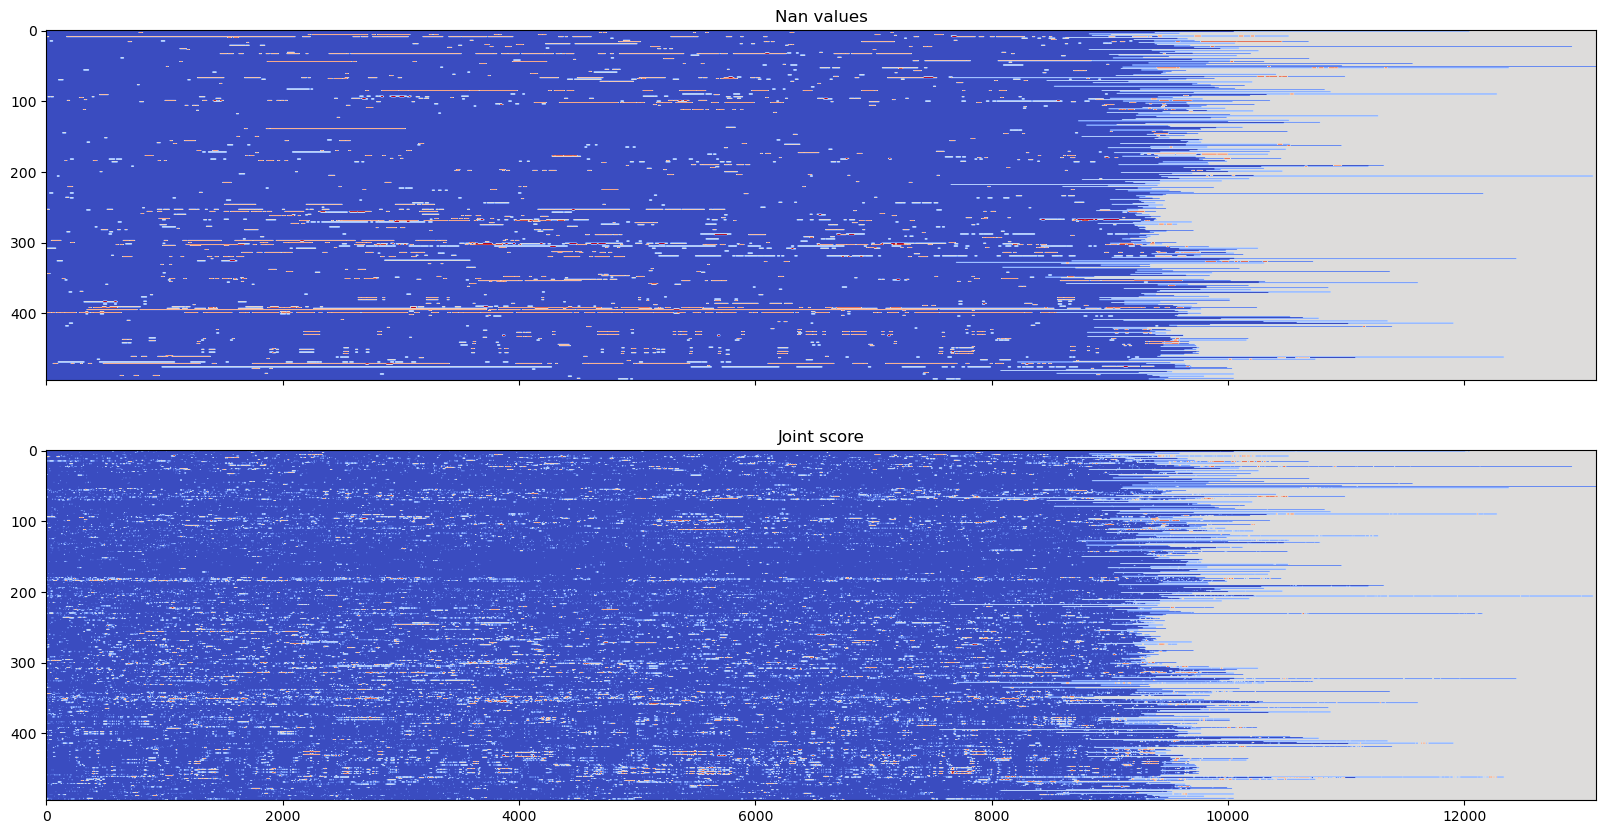

In [8]:
viz_ts_data = [indv_ts[:, 0, 0] for indv_ts in intp_locations]
viz_js_data = [indv_js[:, 0, 0] for indv_js in joint_scores_list]

nan_viz = nan_visualization(viz_ts_data)
js_viz = js_visualization(viz_js_data)

fig, axs = plt.subplots(2, 1, figsize = (20, 10), sharex = True)

axs[0].set_title("Nan values")
axs[1].set_title("Joint score")

axs[0].imshow(nan_viz, cmap = "coolwarm", aspect = "auto")
axs[1].imshow(js_viz, cmap = "coolwarm", aspect = "auto")

In [9]:
print(joint_scores_list[0][np.argwhere(np.isnan(locations_list[0][:, 0, 0, 0])).flatten(), 0, 0]) ## Original
print(joint_scores_list[0][np.argwhere(np.isnan(median_filter_locations[0][:, 0, 0])).flatten(), 0, 0]) ## after median filter
print(joint_scores_list[0][np.argwhere(np.isnan(intp_locations[0][:, 0, 0])).flatten(), 0, 0]) ## after median filter

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan  0.  0.  0.  0.  0. nan nan nan nan nan  0.
 nan nan nan]
[       nan        nan 0.68396926 0.60161668 0.61097598        nan
        nan        nan 0.68401927        nan        nan        nan
        nan 0.57252818 0.49495903        nan        nan 0.
 0.51482904 0.57542527 0.541848          nan 0.59965527        nan
 0.                nan        nan]
[]


In [10]:
quantile_list = [.2, .35, .5, .65, .8]

js_lowscore_list = np.zeros((len(joint_scores_list), 2))

for i, js in enumerate(joint_scores_list):
    m1_score = np.mean(np.nan_to_num(js[:, :, 0]), axis = 0).mean()
    m2_score = np.mean(np.nan_to_num(js[:, :, 1]), axis = 0).mean()

    js_lowscore_list[i] = [m1_score, m2_score]

## Capture videos with the bottom 10% confidence score (averages frames per feature lower than 0.2)

quantile_estimation = np.quantile(js_lowscore_list, axis = 0, q = quantile_list)
print("Low confidence score list quantile estimation")
print(quantile_estimation)
low_cf_m1_idx = np.where(js_lowscore_list[:, 0] <= quantile_estimation[0, 0])[0]
low_cf_m2_idx = np.where(js_lowscore_list[:, 1] <= quantile_estimation[0, 1])[0]

nan_list = np.zeros((len(intp_locations), 2))

for i, il in enumerate(intp_locations):
    m1_nan_il = np.mean([len(np.argwhere(np.isnan(il[:, i, 0]))) for i in range(11)]) / il.shape[0]
    m2_nan_il = np.mean([len(np.argwhere(np.isnan(il[:, i, 1]))) for i in range(11)]) / il.shape[0]

    nan_list[i] = [m1_nan_il, m2_nan_il]

## Capture videos with the highest 10% nan values
qe_nan = np.quantile(nan_list, axis = 0, q = quantile_list)
print("High nan value list quantile estimation")
print(qe_nan)
high_nan_m1_idx = np.where(nan_list[:, 0] >= qe_nan[-1, 0])[0]
high_nan_m2_idx = np.where(nan_list[:, 1] >= qe_nan[-1, 1])[0]

Low confidence score list quantile estimation
[[0.74259544 0.75621953]
 [0.7719778  0.78760395]
 [0.80094091 0.8095116 ]
 [0.82086612 0.82744707]
 [0.83739878 0.84351944]]
High nan value list quantile estimation
[[0.         0.00040029]
 [0.00109331 0.00212984]
 [0.00321505 0.00447902]
 [0.00637793 0.00980008]
 [0.02111218 0.0210633 ]]


In [46]:
## Split the data into m1 and m2 seperately, and get rid of videos with low quality
## Important!

m1_omit_idx = np.intersect1d(high_nan_m1_idx, low_cf_m1_idx)
m2_omit_idx = np.intersect1d(high_nan_m2_idx, low_cf_m2_idx)

m1_imp_cubic_locations = [intp_locations[i][:, :, 0] for i in range(len(intp_locations)) if i not in m1_omit_idx]
m2_imp_cubic_locations = [intp_locations[i][:, :, 1] for i in range(len(intp_locations)) if i not in m2_omit_idx]

m1_js_filtered = [joint_scores_list[i][:, :, 0] for i in range(len(joint_scores_list)) if i not in m1_omit_idx]
m2_js_filtered = [joint_scores_list[i][:, :, 1] for i in range(len(joint_scores_list)) if i not in m2_omit_idx]

In [35]:
m1_imp_dict = {}
m2_imp_dict = {}

for idx, (k, intp_cubic_loc) in enumerate(zip(sample_dict.keys(), intp_locations)):
    if idx not in m1_omit_idx:
        m1_imp_dict[k] = intp_cubic_loc[:, :, 0]
    if idx not in m2_omit_idx:
        m2_imp_dict[k] = intp_cubic_loc[:, :, 1]

# np.save("intact_track_impute_m1_cubic_032023.npy", m1_intp_dict)
# np.save("intact_track_impute_m2_cubic_032023.npy", m2_intp_dict)

In [47]:
len(m1_imp_cubic_locations) / len(imp_locations), len(m2_imp_cubic_locations) / len(imp_locations)

(0.8848484848484849, 0.8686868686868687)

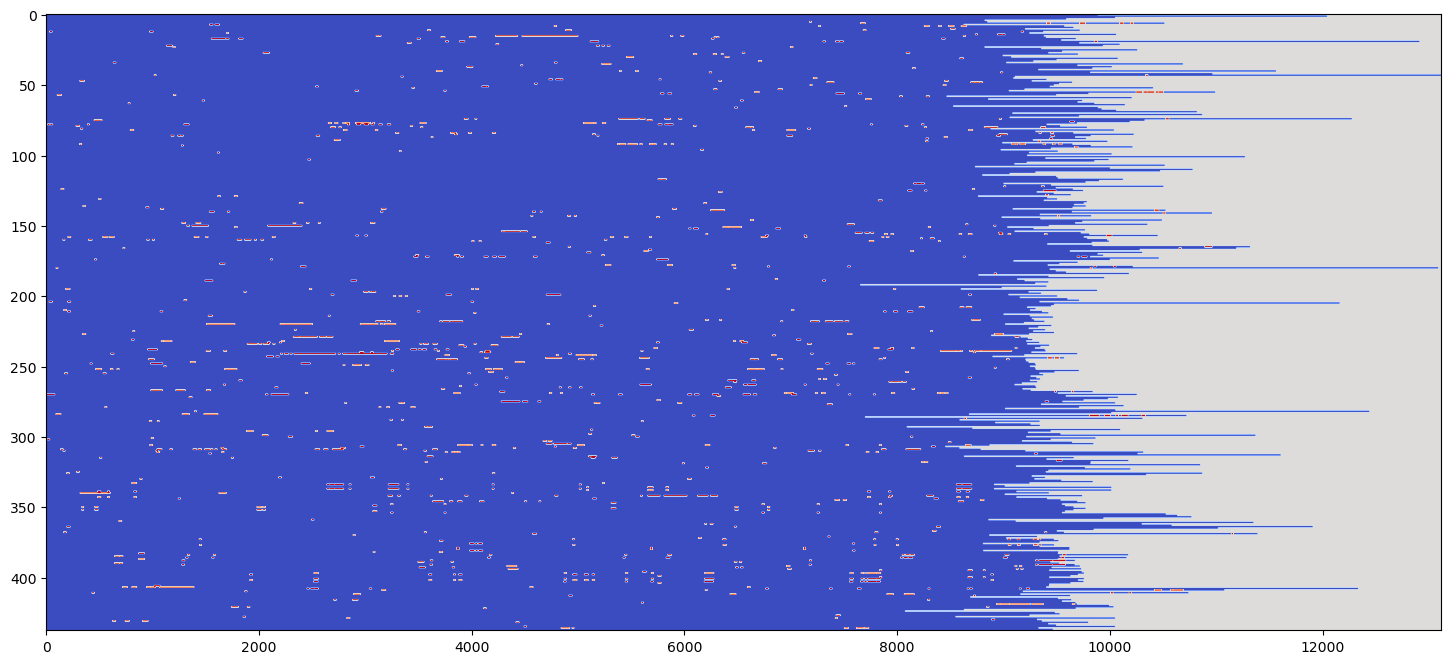

In [48]:
viz_ts_data = [indv_ts[:, 0] for indv_ts in m1_imp_cubic_locations]

nan_viz = nan_visualization(viz_ts_data)

fig, ax = plt.subplots(figsize = (18, 8))
ax.imshow(nan_viz, cmap = "coolwarm", aspect = "auto")

Text(0.5, 1.0, 'Joint average confidence score (m1)')

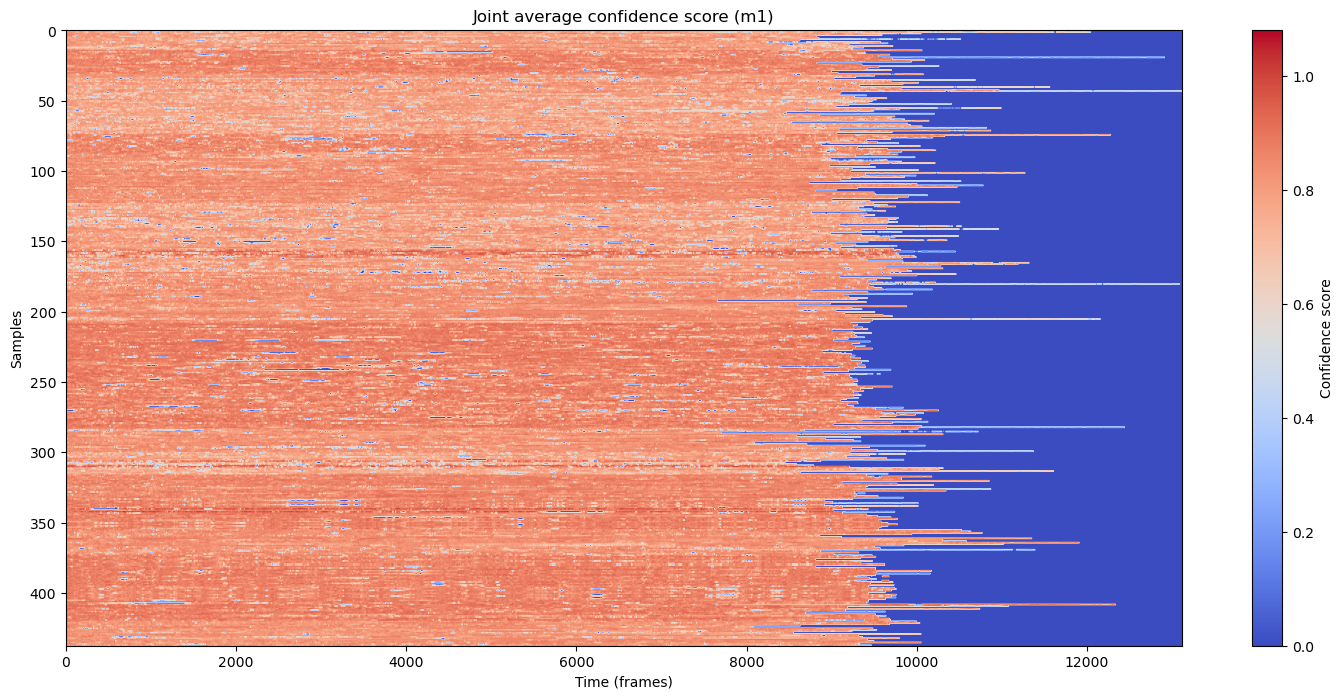

In [14]:
viz_js_data = [np.nan_to_num(indv_js).mean(axis = 1) for indv_js in m1_js_filtered]

max_len = max([sample.shape[0] for sample in viz_js_data])

# Create a numpy array to hold all samples
all_samples = np.zeros((len(viz_js_data), max_len))

# Fill in each sample
for i, sample in enumerate(viz_js_data):
    all_samples[i, :sample.shape[0]] = sample

fig, ax = plt.subplots(figsize = (18, 8))
f = ax.imshow(all_samples, aspect = "auto", cmap = "coolwarm")
plt.colorbar(f, label = "Confidence score")
ax.set_ylabel("Samples")
ax.set_xlabel("Time (frames)")

ax.set_title("Joint average confidence score (m1)")

In [16]:
## Look at how nans are distributions over time 
filtered_count_nan = np.array([np.isnan(i).sum() for i in m1_imp_cubic_locations])
high_nan_idx = np.where(filtered_count_nan > np.quantile(filtered_count_nan, .9))[0]
# for i in high_nan_idx[:10]:
#     fig, ax = plt.subplots(figsize = (18, 8))
#     f = ax.imshow(np.where(np.nan_to_num(m1_intp_locations[i]) == 0, -1, 1).T, aspect = "auto", cmap = "gray_r")
#     ax.set_yticks(np.arange(22))
#     ax.set_title(f"Video number {i} with {filtered_count_nan[i]} nans")
#     plt.colorbar(f)
#     plt.show()
#     plt.close()

In [17]:
### Randomforest regressor
# 1. identify regions that
thold = .3

test_arr = m1_imp_cubic_locations[high_nan_idx[0]]
nan_areas = [identify_continuous_nans(test_arr[:, i]) for i in range(22)]
rf_avail_idx = []

for idx, features in enumerate(nan_areas):
    pp_arr = []
    select_f = np.delete(np.arange(22), idx)
    for reg in features:
        start = reg[0]
        end = reg[1]

        test_arr_bound = np.isnan(test_arr[start: end, select_f]).sum() / ((end - start) * 21)
        if test_arr_bound <= thold:
            rf_avail_idx.append((idx, np.round(test_arr_bound, 2), start, end))

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
/home/tt1131/.conda/envs/general/lib/python3.9/site-packages/daal4py/sklearn/ensemble/_forest.py:57: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warnings.warn(


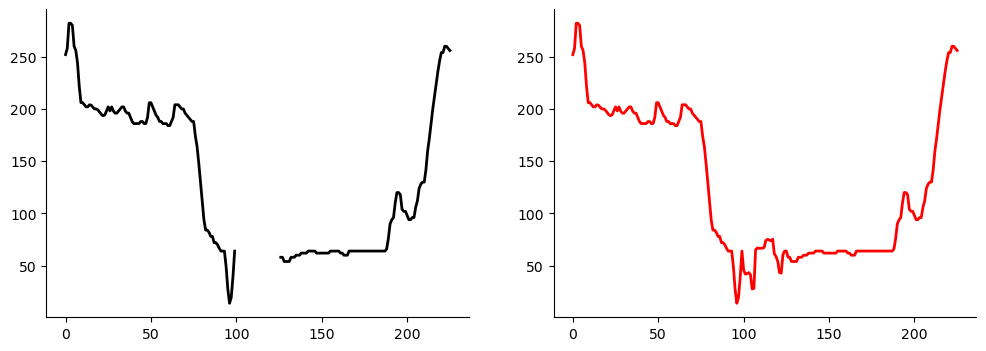

In [18]:
from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.ensemble import RandomForestRegressor

rf_regr = RandomForestRegressor(random_state=42)
test_nan_region = rf_avail_idx[0]
y_idx = test_nan_region[0]
start = test_nan_region[2]
end = test_nan_region[3]
time_nonan_idx = np.unique(np.argwhere(np.isnan(test_arr))[:, 0])
avail_xt_idx = np.delete(np.arange(test_arr.shape[0]), time_nonan_idx)

X_idx = np.delete(np.arange(22), y_idx)

rf_regr.fit(test_arr[avail_xt_idx, :][:, X_idx], test_arr[avail_xt_idx, :][:, y_idx])
rf_impute_arr = rf_regr.predict(np.nan_to_num(test_arr[start: end, X_idx]))

test_arr_impute = np.copy(test_arr)
test_arr_impute[start: end, y_idx] = rf_impute_arr

fig, axs = plt.subplots(1, 2, figsize = (12, 4))

axs[0].plot(test_arr[start - 100: end + 100, y_idx], lw = 2, c = "k")
axs[1].plot(test_arr_impute[start - 100: end + 100, y_idx], lw = 2, c = "r")

sns.despine()

/home/tt1131/.conda/envs/general/lib/python3.9/site-packages/daal4py/sklearn/ensemble/_forest.py:57: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warnings.warn(
/home/tt1131/.conda/envs/general/lib/python3.9/site-packages/daal4py/sklearn/ensemble/_forest.py:57: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warnings.warn(
/home/tt1131/.conda/envs/general/lib/python3.9/site-packages/daal4py/sklearn/ensemble/_forest.py:57: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set 

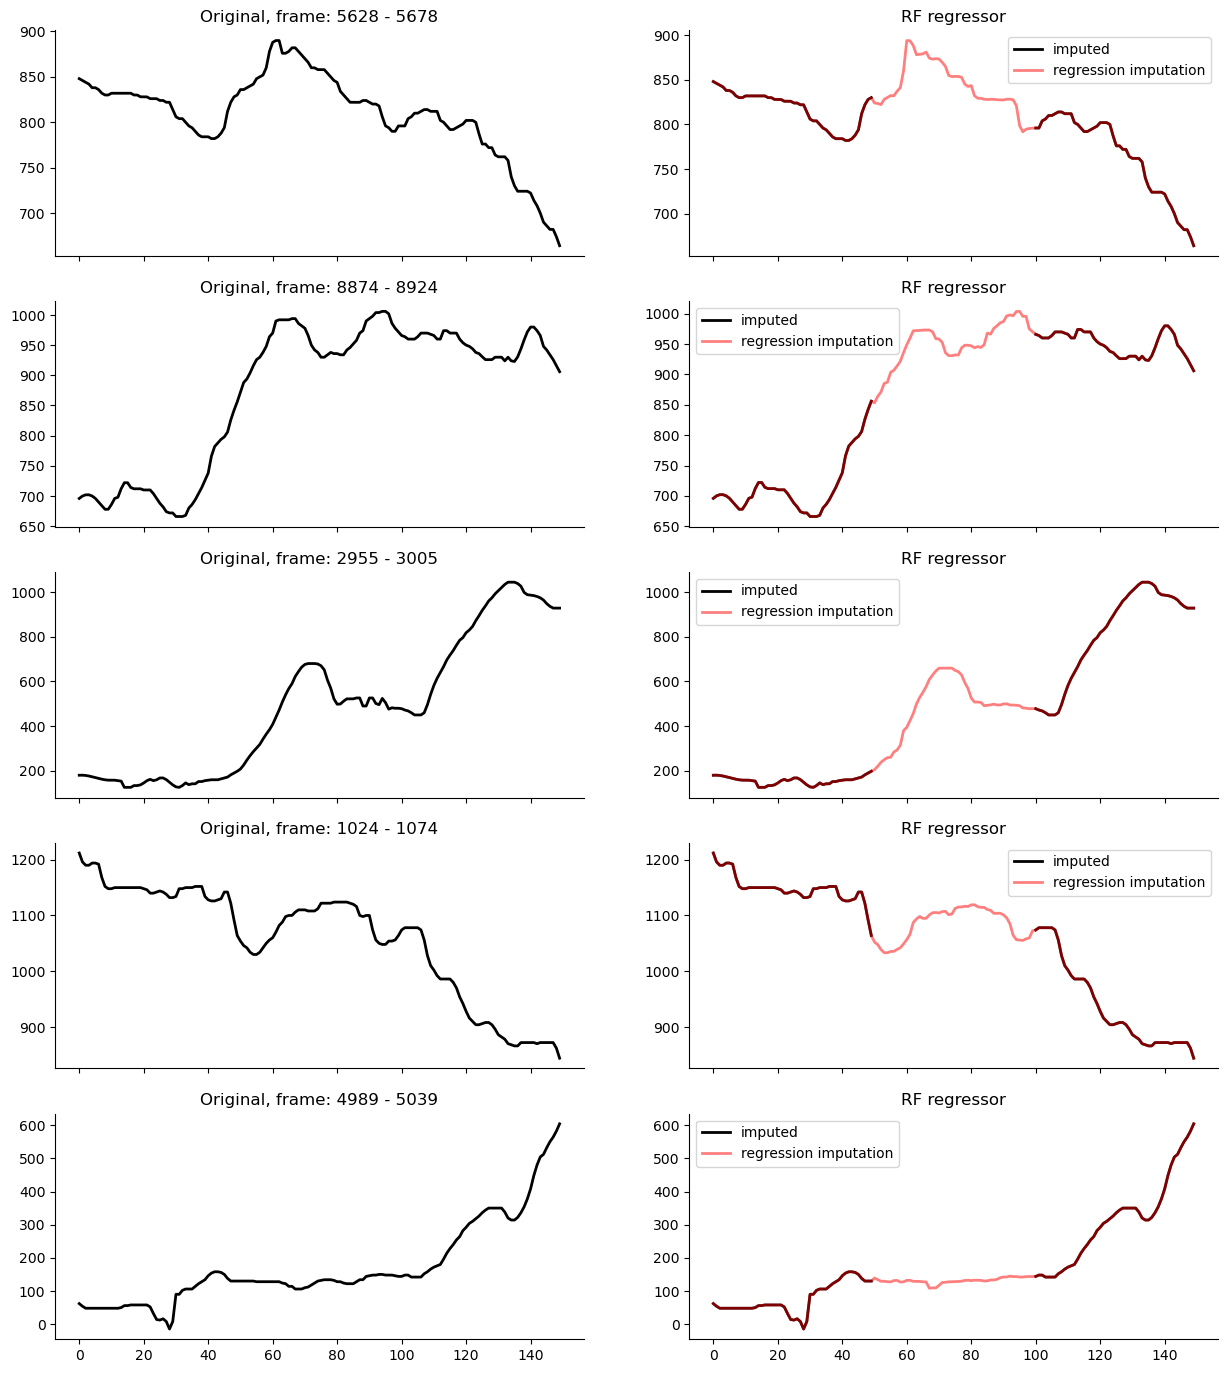

In [19]:
time_seg_length = 50
sample_size = 5

fig, axs = plt.subplots(sample_size, 2, figsize = (15, 17), sharex = True)
rf_test_results = []
random_start_list = []

for i in range(sample_size):
    random_seg_start = np.random.choice(avail_xt_idx)
    test_arr_copy = np.copy(test_arr)
    test_arr_copy[random_seg_start: random_seg_start + time_seg_length, y_idx] = np.nan

    axs[i, 0].plot(test_arr[random_seg_start - 50: random_seg_start + time_seg_length + 50, y_idx], lw = 2, c = "k")
    axs[i, 1].plot(test_arr_copy[random_seg_start - 50: random_seg_start + time_seg_length + 50, y_idx], 
                lw = 2, c = "k", label = "imputed")

    time_nonan_idx = np.unique(np.argwhere(np.isnan(test_arr_copy))[:, 0])
    avail_xt_idx = np.delete(np.arange(test_arr.shape[0]), time_nonan_idx)

    X_idx = np.delete(np.arange(22), y_idx)

    rf_regr.fit(test_arr[avail_xt_idx, :][:, X_idx], test_arr[avail_xt_idx, :][:, y_idx])
    rf_impute_arr = rf_regr.predict(np.nan_to_num(test_arr[random_seg_start: random_seg_start + time_seg_length, X_idx]))

    test_arr_copy[random_seg_start: random_seg_start + time_seg_length, y_idx] = rf_impute_arr
    axs[i, 1].plot(test_arr_copy[random_seg_start - 50: random_seg_start + time_seg_length + 50, y_idx], 
                lw = 2, c = "r", label = "regression imputation", alpha = .5)

    axs[i, 0].set_title(f"Original, frame: {random_seg_start} - {random_seg_start + time_seg_length}")
    axs[i, 1].set_title("RF regressor")
    axs[i, 1].legend()
    rf_test_results.append(test_arr_copy)
    random_start_list.append(random_seg_start)

sns.despine()

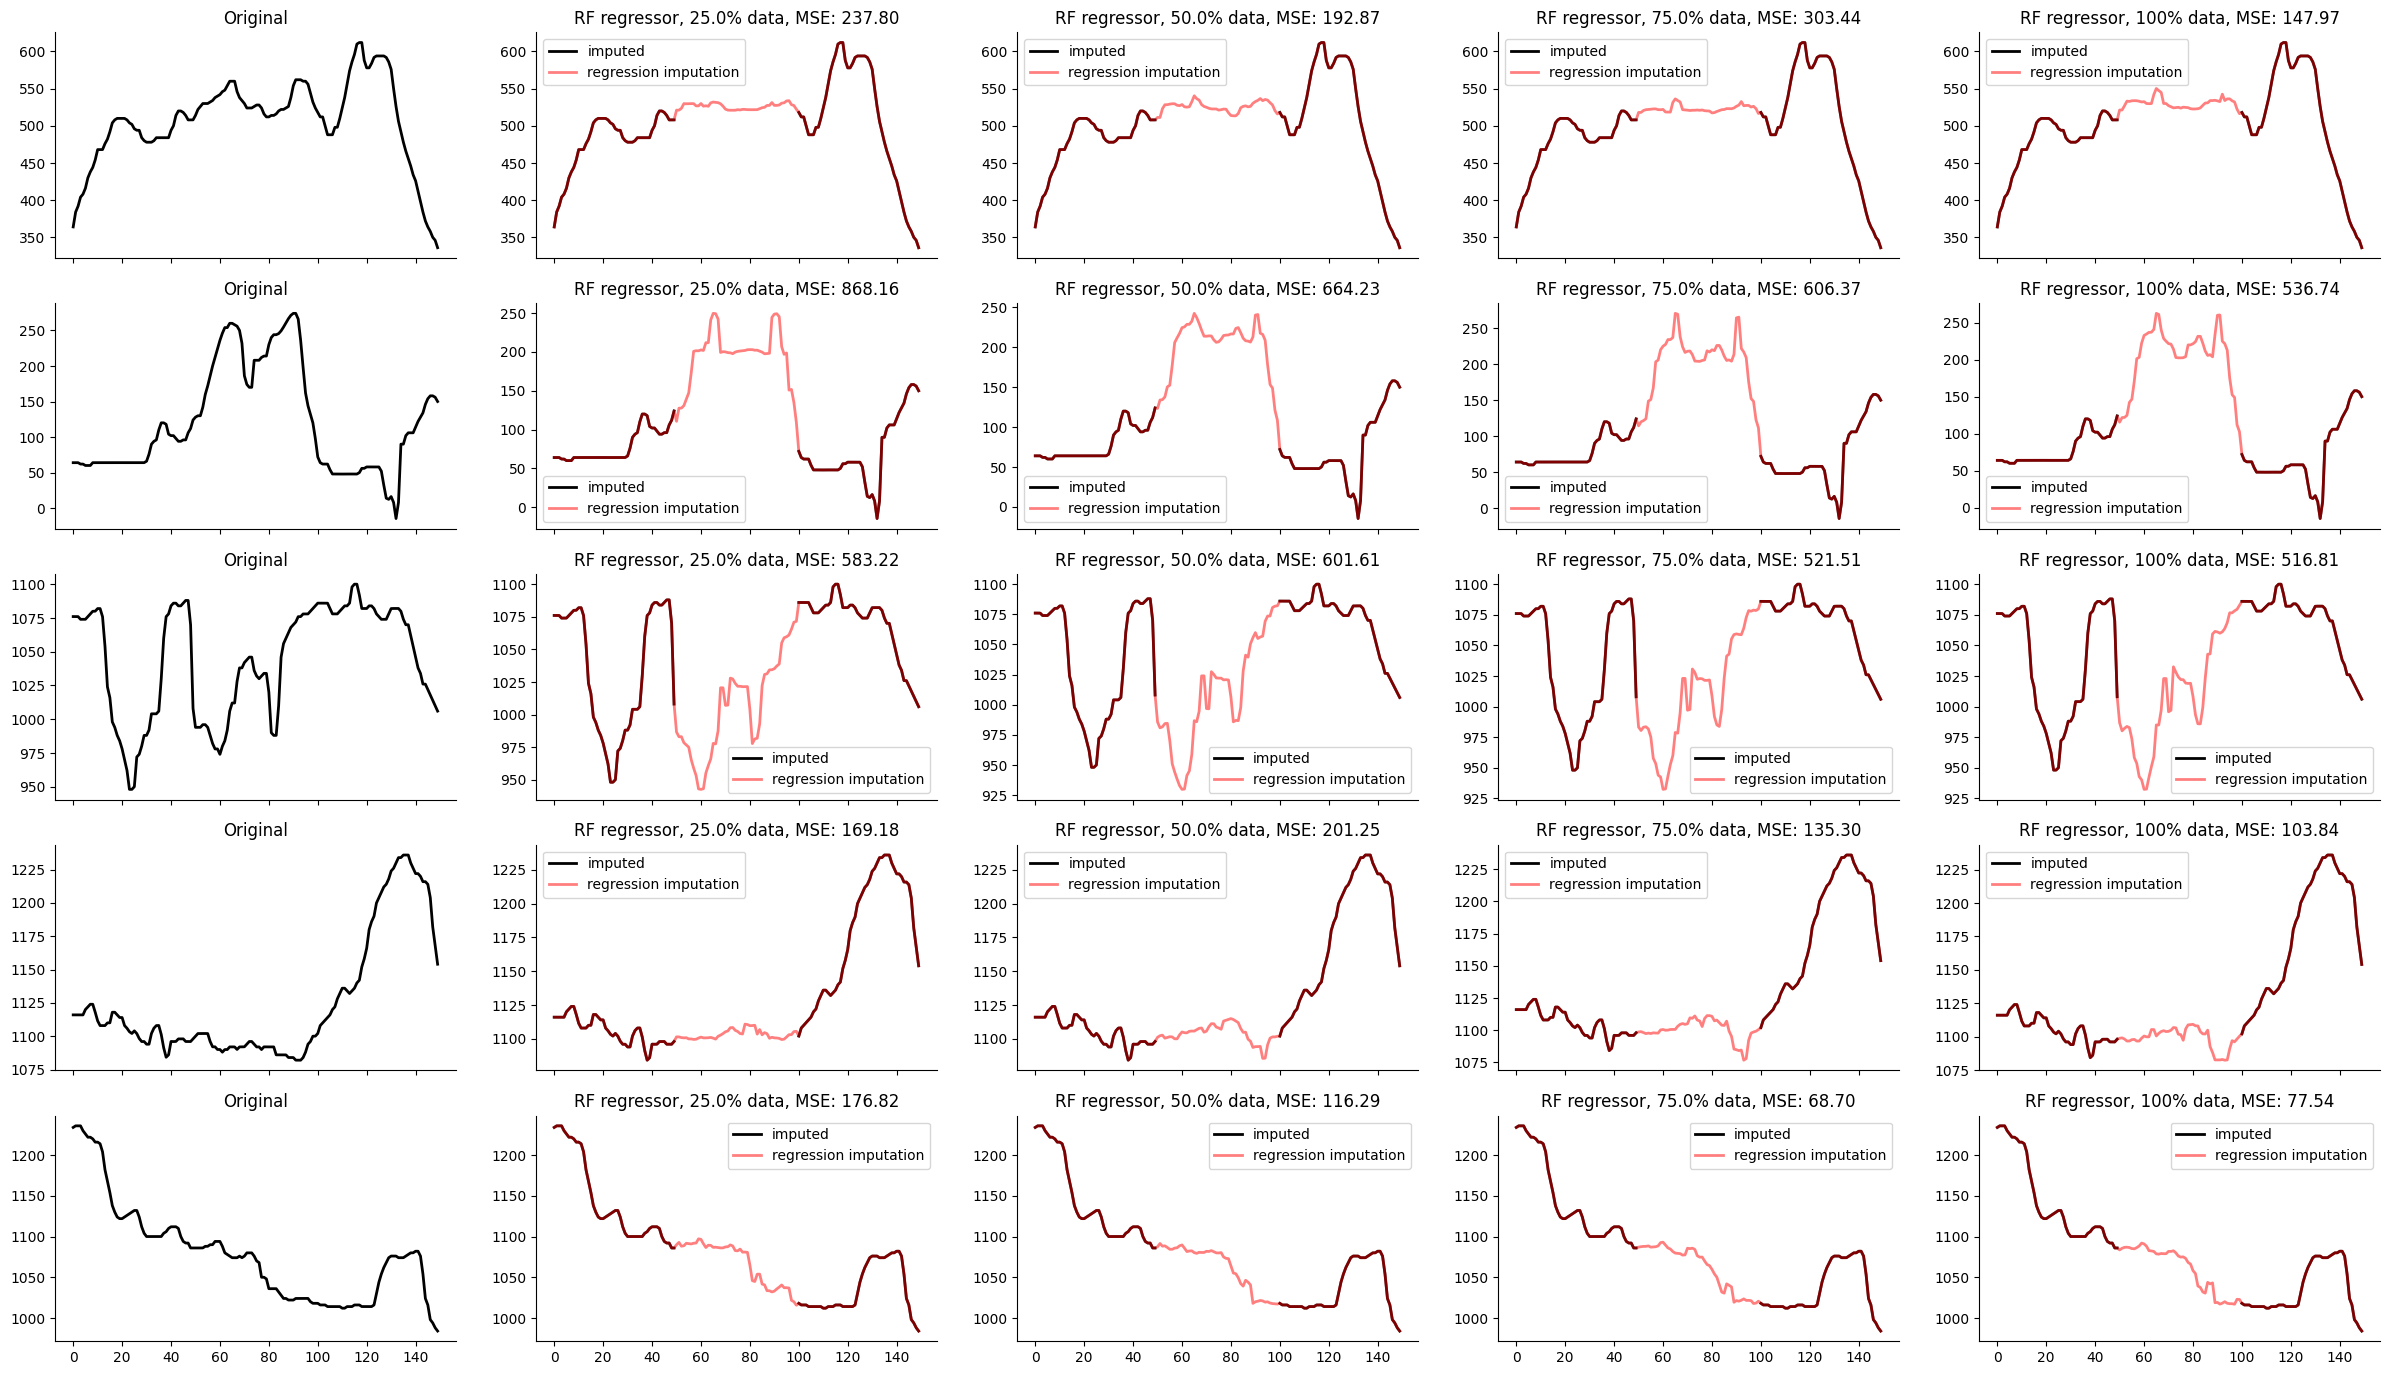

In [433]:
from sklearn.metrics import mean_squared_error

time_seg_length = 50
sample_size = 5

fig, axs = plt.subplots(sample_size, 5, figsize = (30, 17), sharex = True)

for i in range(sample_size):
    random_seg_start = np.random.choice(avail_xt_idx)
    X_idx = np.delete(np.arange(22), y_idx)

    test_arr_copy = np.copy(test_arr)
    test_arr_copy[random_seg_start: random_seg_start + time_seg_length, y_idx] = np.nan
    time_nonan_idx = np.unique(np.argwhere(np.isnan(test_arr_copy))[:, 0])
    avail_xt_idx = np.delete(np.arange(test_arr.shape[0]), time_nonan_idx)

    axs[i, 0].plot(test_arr[random_seg_start - 50: random_seg_start + time_seg_length + 50, y_idx], lw = 2, c = "k", label = "original")
    axs[i, 0].set_title("Original")
        
    for j, percent in enumerate([.25, .5, .75, 1]):
        test_arr_copy[random_seg_start: random_seg_start + time_seg_length, y_idx] = np.nan
        axs[i, j + 1].plot(test_arr_copy[random_seg_start - 50: random_seg_start + time_seg_length + 50, y_idx], 
                    lw = 2, c = "k", label = "imputed")
        
        rf_regr = RandomForestRegressor(random_state=42)
        random_idx = np.random.choice(avail_xt_idx, int(len(avail_xt_idx) * percent), replace = False)
        
        rf_regr.fit(test_arr[random_idx, :][:, X_idx], test_arr[random_idx, :][:, y_idx])
        rf_impute_arr = rf_regr.predict(np.nan_to_num(test_arr[random_seg_start: random_seg_start + time_seg_length, X_idx]))

        test_arr_copy[random_seg_start: random_seg_start + time_seg_length, y_idx] = rf_impute_arr
        mse_err = mean_squared_error(test_arr[random_seg_start: random_seg_start + time_seg_length, y_idx], rf_impute_arr)
        
        axs[i, j + 1].plot(test_arr_copy[random_seg_start - 50: random_seg_start + time_seg_length + 50, y_idx], 
                    lw = 2, c = "r", label = "regression imputation", alpha = .5)

        axs[i, j + 1].set_title(f"RF regressor, {percent * 100}% data, MSE: {mse_err:.2f}")
        axs[i, j + 1].legend()

sns.despine()

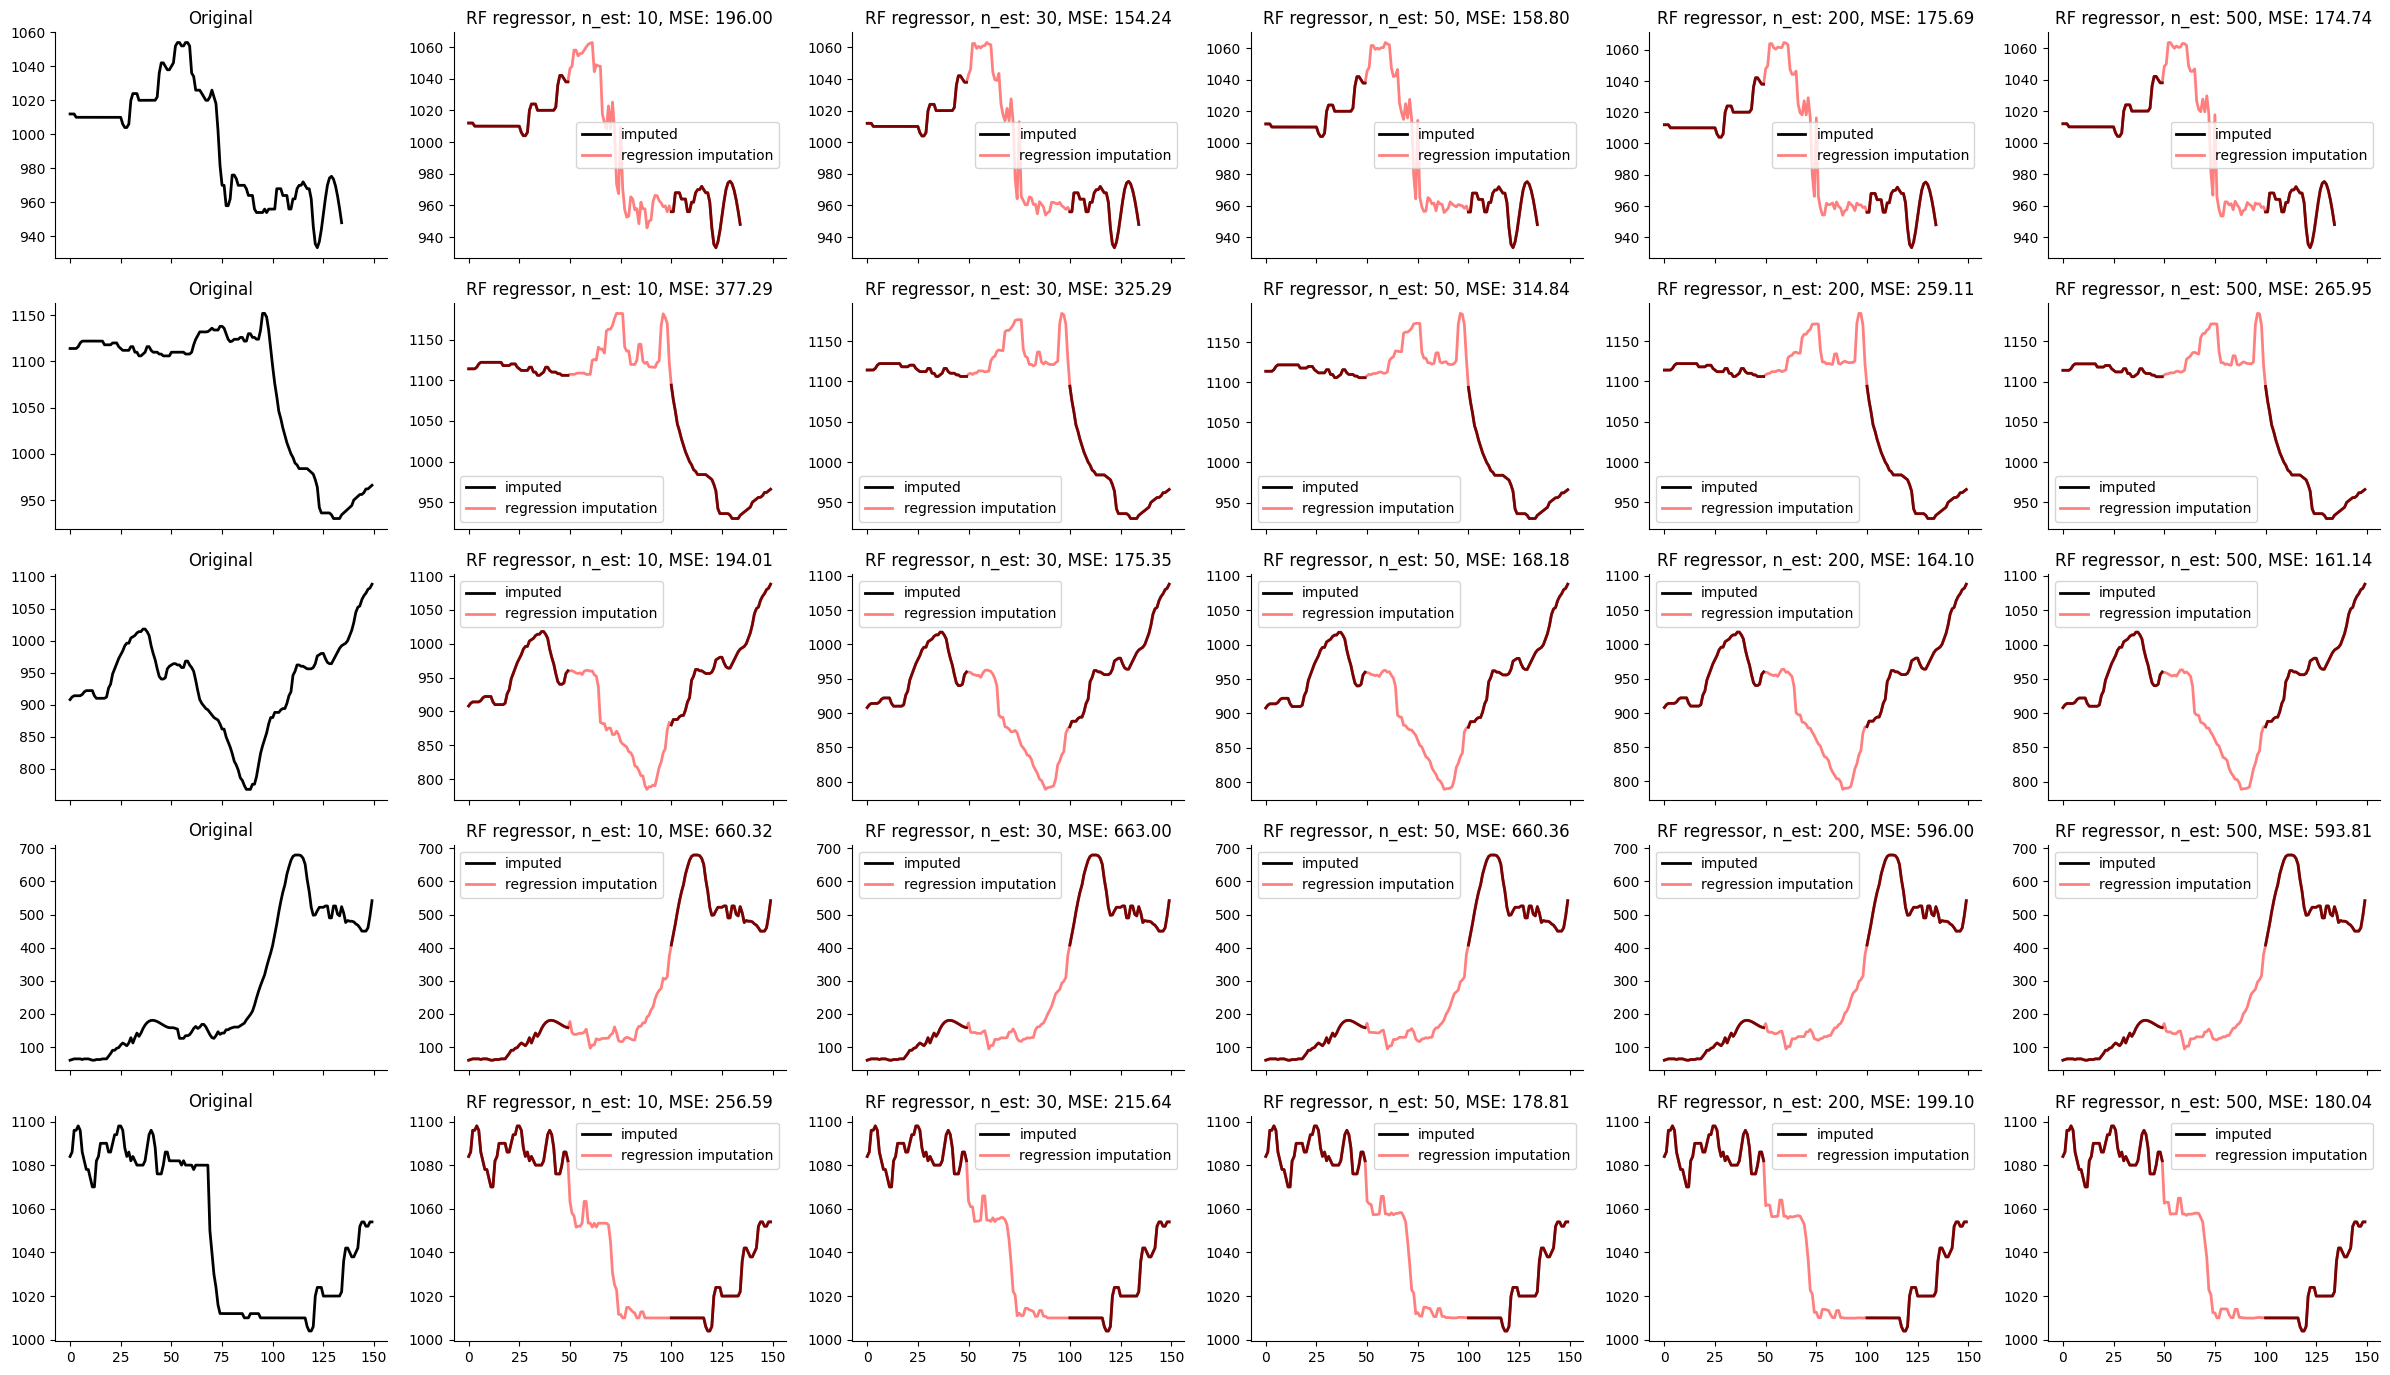

In [436]:
from sklearn.metrics import mean_squared_error

time_seg_length = 50
sample_size = 5

fig, axs = plt.subplots(sample_size, 6, figsize = (30, 17), sharex = True)

for i in range(sample_size):
    random_seg_start = np.random.choice(avail_xt_idx)
    X_idx = np.delete(np.arange(22), y_idx)

    test_arr_copy = np.copy(test_arr)
    test_arr_copy[random_seg_start: random_seg_start + time_seg_length, y_idx] = np.nan
    time_nonan_idx = np.unique(np.argwhere(np.isnan(test_arr_copy))[:, 0])
    avail_xt_idx = np.delete(np.arange(test_arr.shape[0]), time_nonan_idx)

    axs[i, 0].plot(test_arr[random_seg_start - 50: random_seg_start + time_seg_length + 50, y_idx], lw = 2, c = "k", label = "original")
    axs[i, 0].set_title("Original")
        
    for j, nest in enumerate([10, 30, 50, 200, 500]):
        test_arr_copy[random_seg_start: random_seg_start + time_seg_length, y_idx] = np.nan
        axs[i, j + 1].plot(test_arr_copy[random_seg_start - 50: random_seg_start + time_seg_length + 50, y_idx], 
                    lw = 2, c = "k", label = "imputed")
        
        rf_regr = RandomForestRegressor(random_state=42, n_estimators=nest)
        
        rf_regr.fit(test_arr[avail_xt_idx, :][:, X_idx], test_arr[avail_xt_idx, :][:, y_idx])
        rf_impute_arr = rf_regr.predict(np.nan_to_num(test_arr[random_seg_start: random_seg_start + time_seg_length, X_idx]))

        test_arr_copy[random_seg_start: random_seg_start + time_seg_length, y_idx] = rf_impute_arr
        mse_err = mean_squared_error(test_arr[random_seg_start: random_seg_start + time_seg_length, y_idx], rf_impute_arr)
        
        axs[i, j + 1].plot(test_arr_copy[random_seg_start - 50: random_seg_start + time_seg_length + 50, y_idx], 
                    lw = 2, c = "r", label = "regression imputation", alpha = .5)

        axs[i, j + 1].set_title(f"RF regressor, n_est: {nest}, MSE: {mse_err:.2f}")
        axs[i, j + 1].legend()

sns.despine()

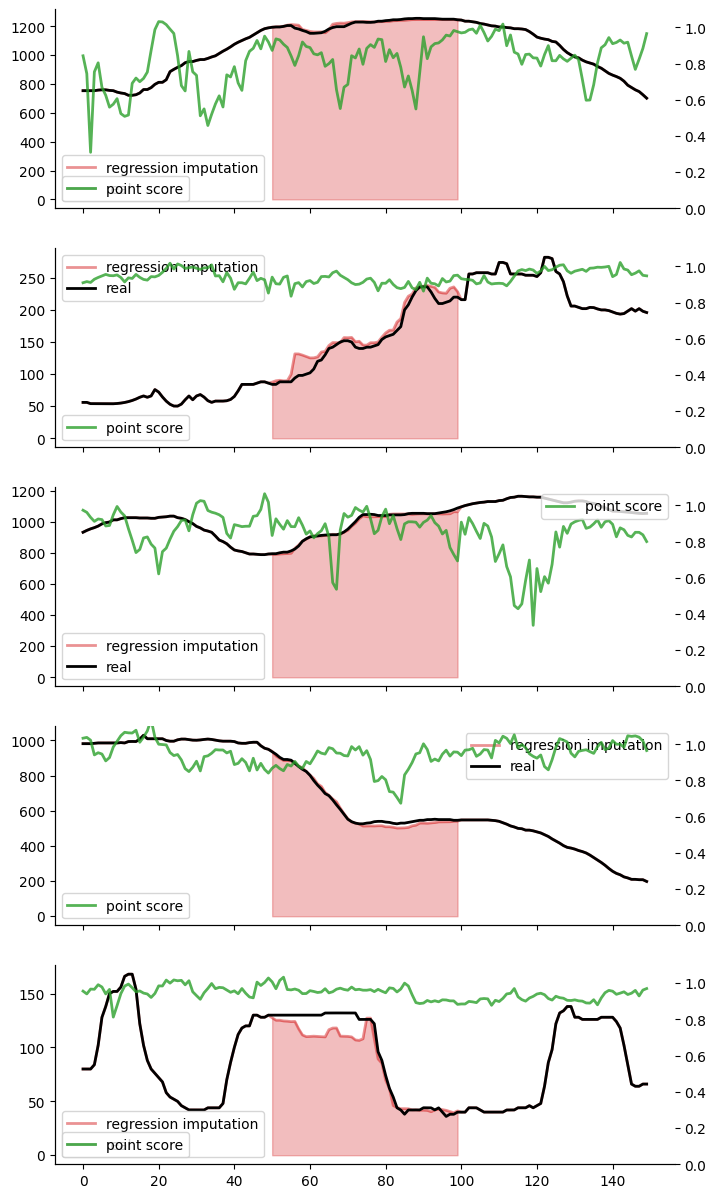

In [426]:
## Use the new rfregressed imputation and check with point score

test_point_score = joint_scores_list[high_nan_idx[0]][:, :, 0]

fig, axs = plt.subplots(5, 1, figsize = (8, 15), sharex = True)
for i, (rf_arr, rs) in enumerate(zip(rf_test_results, random_start_list)):
    axs[i].plot(rf_arr[rs - 50: rs + time_seg_length + 50, y_idx], lw = 2, c = "tab:red", alpha = .5, label = "regression imputation")
    axs[i].plot(test_arr[rs - 50: rs + time_seg_length + 50, y_idx], lw = 2, c = "k", label = "real")
    axs[i].fill_between(np.arange(50, time_seg_length + 50), 
                         rf_arr[rs: rs + time_seg_length, y_idx], 
                         alpha = .3, color = "tab:red")
    axs[i].legend()

    ax_score = axs[i].twinx()
    ax_score.plot(test_point_score[rs - 50: rs + time_seg_length + 50, y_idx], lw = 2, c = "tab:green", 
                  label = "point score", alpha = .8)
    ax_score.set_ylim(0, 1.1)

    ax_score.legend()

sns.despine()

In [20]:
### After doing all these preliminary tests, we scale to all regions across all samples with the same method
### Using the entire video as training set
### Randomforest regressor

# 1. identify regions that have other joints for multivariate imputation
thold = .3

test_arr = m1_intp_locations[high_nan_idx[0]]
nan_areas = [identify_continuous_nans(test_arr[:, i]) for i in range(22)]
rf_avail_idx = []

for idx, features in enumerate(nan_areas):
    pp_arr = []
    select_f = np.delete(np.arange(22), idx)
    for reg in features:
        start = reg[0]
        end = reg[1]

        test_arr_bound = np.isnan(test_arr[start: end, select_f]).sum() / ((end - start) * 21)
        if test_arr_bound <= thold:
            rf_avail_idx.append((idx, np.round(test_arr_bound, 2), start, end))


n_estimators = 50
test_arr_impute = np.copy(test_arr)

time_nonan_idx = np.unique(np.argwhere(np.isnan(test_arr))[:, 0])
avail_xt_idx = np.delete(np.arange(test_arr.shape[0]), time_nonan_idx)
training_X = test_arr[avail_xt_idx, :]

for rf_region in tqdm(rf_avail_idx):
    y_idx = rf_region[0]
    start = rf_region[2]
    end = rf_region[3]

    rf_regr = RandomForestRegressor(random_state=42, n_estimators=n_estimators, max_features=1.0)
    X_idx = np.delete(np.arange(22), y_idx)
    rf_regr.fit(training_X[:, X_idx], training_X[:, y_idx])
    rf_impute_y = rf_regr.predict(np.nan_to_num(test_arr[start: end, X_idx]))

    test_arr_impute[start: end, y_idx] = rf_impute_y

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.94it/s]


Text(0.5, 1.0, 'After rf imputation')

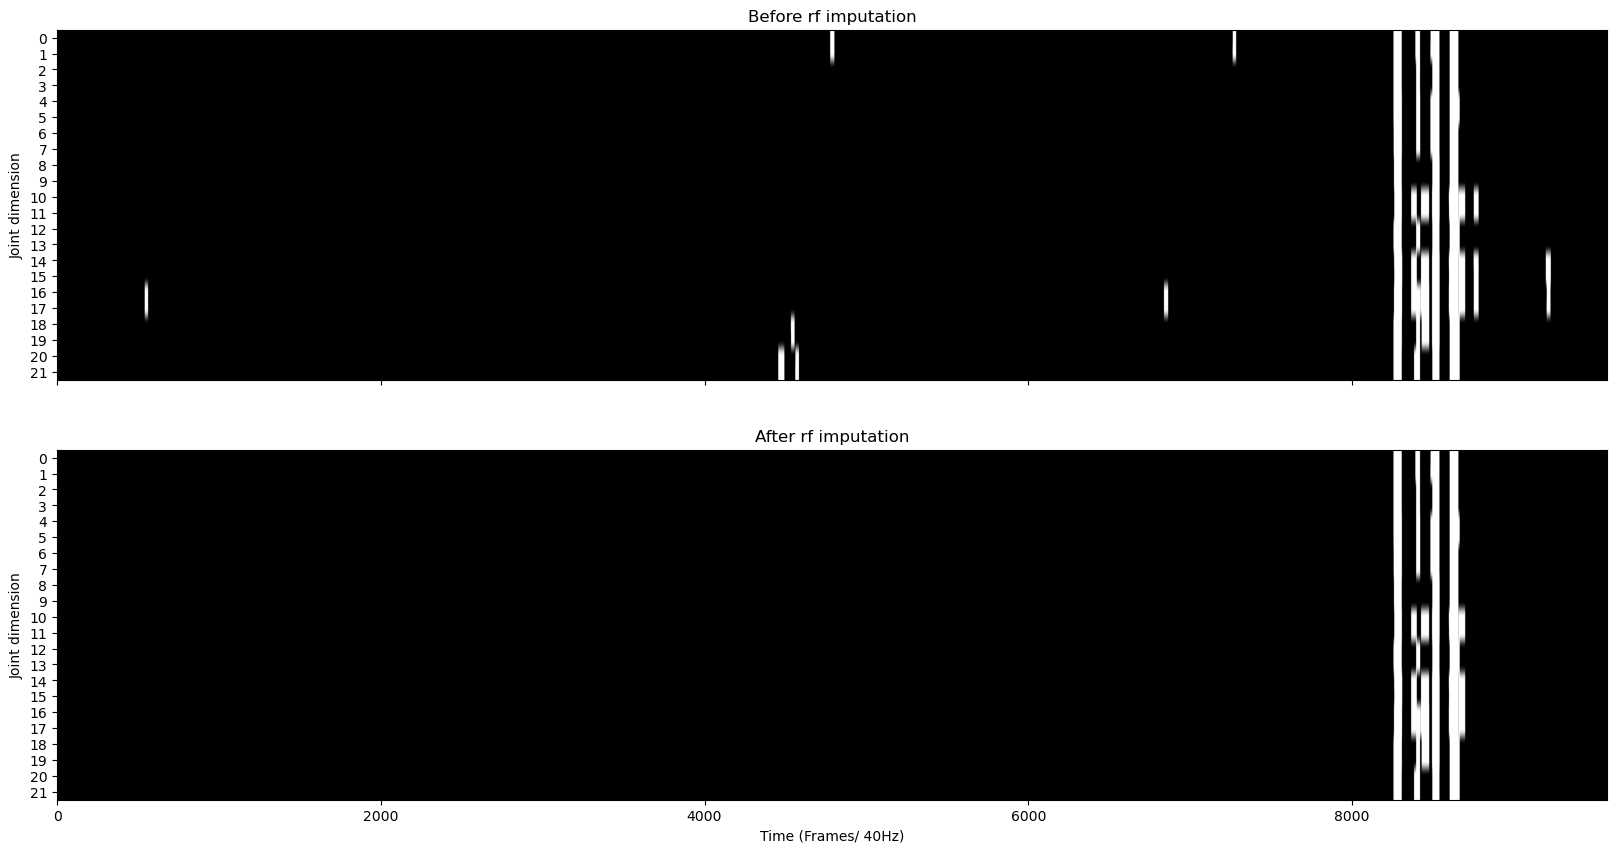

In [21]:
fig, axs = plt.subplots(2, 1, figsize = (20, 10), sharex = True, sharey = True)

axs[0].imshow(np.where(np.isnan(test_arr), 0, 1).T, aspect = "auto", cmap = "gray_r")
axs[1].imshow(np.where(np.isnan(test_arr_impute), 0, 1).T, aspect = "auto", cmap = "gray_r")

axs[0].set_yticks(np.arange(22))
axs[0].set_ylabel("Joint dimension")
axs[1].set_ylabel("Joint dimension")
axs[1].set_xlabel("Time (Frames/ 40Hz)")

axs[0].set_title("Before rf imputation")
axs[1].set_title("After rf imputation")

In [26]:
def rf_impute(arr: np.ndarray, nan_threshold: int, n_estimators: int) -> np.ndarray:
    """Impute missing values with random forest regressor, only continuous regions of 
    total nan proportion under threshold will be considered

    Args:
        arr (np.ndarray): input array of dimension (Time, Features)
        nan_threshold (int): threshold of total nan proportion in a continuous region
        n_estimators (int): Number of estimators in random forest regressor

    Return:
        rf_avail_idx (list): list of tuples of (feature index, nan proportion, start, end)
        arr_impute (np.ndarray): imputed array of dimension (Time, Features)
    """
    feature_range = np.arange(arr.shape[1])
    nan_areas = [identify_continuous_nans(arr[:, i]) for i in range(arr.shape[1])]
    
    rf_avail_idx = []
    for idx, features in enumerate(nan_areas):
        select_f = np.delete(feature_range, idx)
        for reg in features:
            start = reg[0]
            end = reg[1]

            arr_bound = np.isnan(arr[start: end, select_f]).sum() / ((end - start) * (arr.shape[1] - 1))
            if arr_bound <= nan_threshold:
                rf_avail_idx.append((idx, np.round(arr_bound, 2), start, end))
    # print(f"There are {len(rf_avail_idx)} regions with {nan_threshold} NaN threshold found, start imputation...")

    rf_regr = RandomForestRegressor(random_state = 42, n_estimators = n_estimators, n_jobs = -1, max_features=1.0)
    arr_impute = np.copy(arr)
    avail_xt_idx = np.delete(np.arange(arr.shape[0]), np.unique(np.argwhere(np.isnan(arr))[:, 0]))
    training_X = arr[avail_xt_idx, :]
    
    for i, rf_region in enumerate(rf_avail_idx):
        y_idx = rf_region[0]
        start = rf_region[2]
        end = rf_region[3]

        X_idx = np.delete(feature_range, y_idx)
        rf_regr.fit(training_X[:, X_idx], training_X[:, y_idx])
            
        rf_impute_y = rf_regr.predict(np.nan_to_num(arr[start: end, X_idx]))
        arr_impute[start: end, y_idx] = rf_impute_y
        
    return rf_avail_idx, arr_impute

In [27]:
impute_rf_locations = []
threshold = .3
n_estimators = 50
for ts in track(intp_locations):
    _, m1_imp_rf = rf_impute(ts[:, :, 0], threshold, n_estimators)
    _, m2_imp_rf = rf_impute(ts[:, :, 1], threshold, n_estimators)
    impute_rf_locations.append(np.stack([m1_imp_rf, m2_imp_rf], axis=-1))

Output()

In [37]:
m1_imp_rf_dict = {}
m2_imp_rf_dict = {}
m1_imp_rf_loc = []
m2_imp_rf_loc = []

for idx, (k, intp_rf_loc) in enumerate(zip(sample_dict.keys(), impute_rf_locations)):
    if idx not in m1_omit_idx:
        m1_imp_rf_dict[k] = intp_rf_loc[:, :, 0]
        m1_imp_rf_loc.append(intp_rf_loc[:, :, 0])
    if idx not in m2_omit_idx:
        m2_imp_rf_dict[k] = intp_rf_loc[:, :, 1]
        m2_imp_rf_loc.append(intp_rf_loc[:, :, 1])

# np.save("intact_track_impute_m1_cubic_rf_032023.npy", m1_imp_rf_dict)
# np.save("intact_track_impute_m2_cubic_rf_032023.npy", m2_imp_rf_dict)

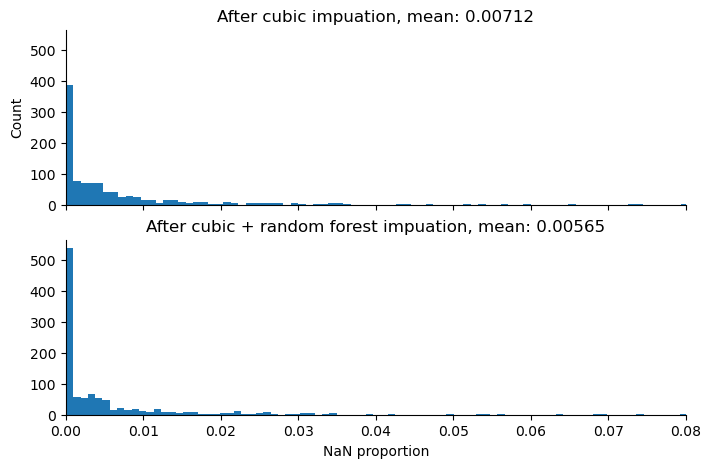

In [63]:
m1_imp_rf_nan = np.array([np.isnan(m1_imp_rf_loc[i]).sum() / (m1_imp_rf_loc[i].shape[0] * m1_imp_rf_loc[i].shape[1]) for i in range(len(m1_imp_rf_loc))])
m1_imp_nan = np.array([np.isnan(m1_imp_cubic_locations[i]).sum()  / (m1_imp_cubic_locations[i].shape[0] * m1_imp_cubic_locations[i].shape[1]) for i in range(len(m1_imp_cubic_locations))])

fig, axs = plt.subplots(2, 1, figsize = (8, 5), sharex = True, sharey = True)
axs[0].set_xlim(0, 0.08)

axs[0].set_ylabel("Count")
axs[1].set_xlabel("NaN proportion")

axs[0].hist(m1_imp_nan, bins = 100, density = True)
axs[1].hist(m1_imp_rf_nan, bins = 100, density = True)

axs[0].set_title(f"After cubic impuation, mean: {np.round(m1_imp_nan.mean(), 5)}")
axs[1].set_title(f"After cubic + random forest impuation, mean: {np.round(m1_imp_rf_nan.mean(), 5)}")

sns.despine()

In [84]:
len(np.where(m1_imp_rf_nan == 0)[0])

219

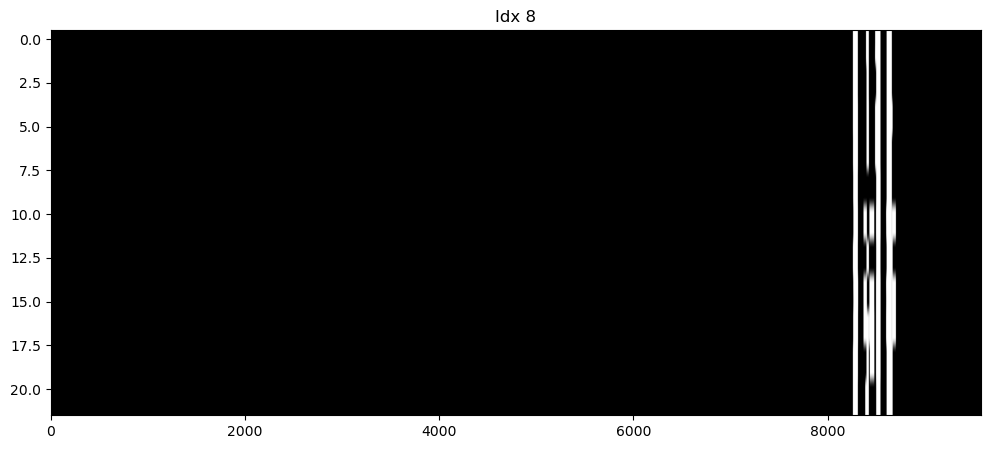

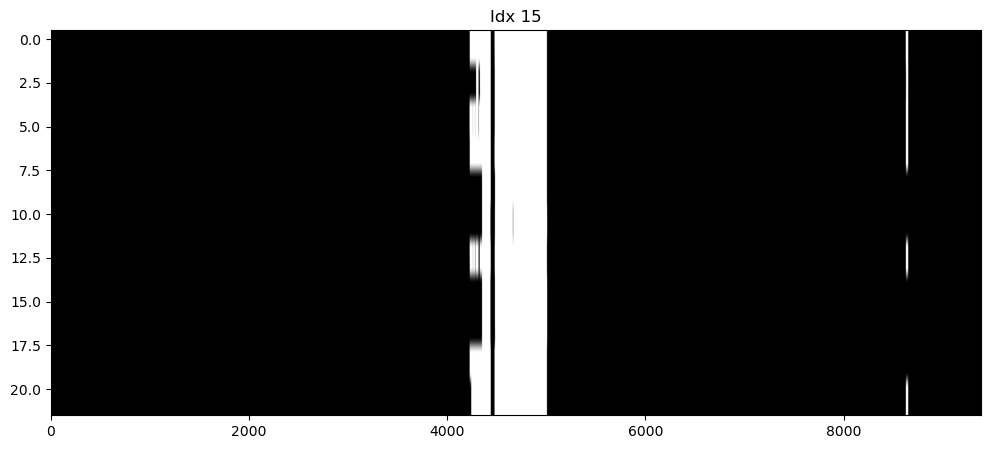

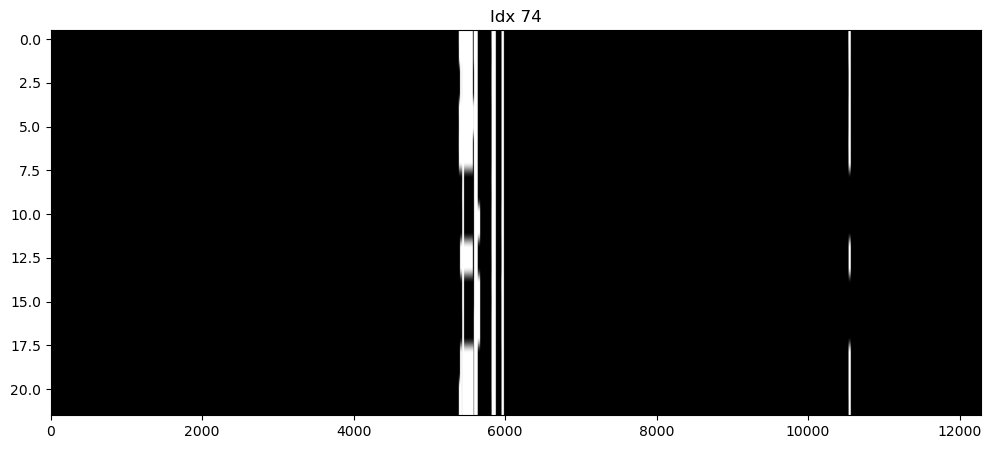

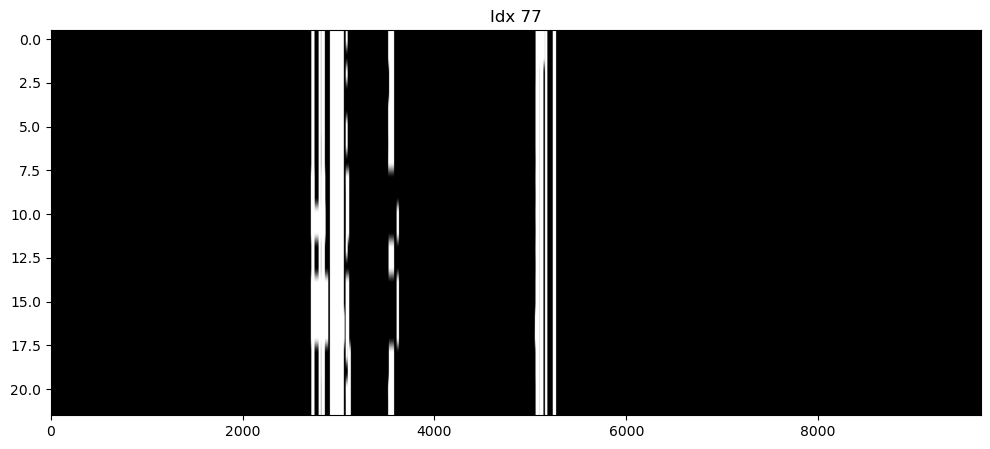

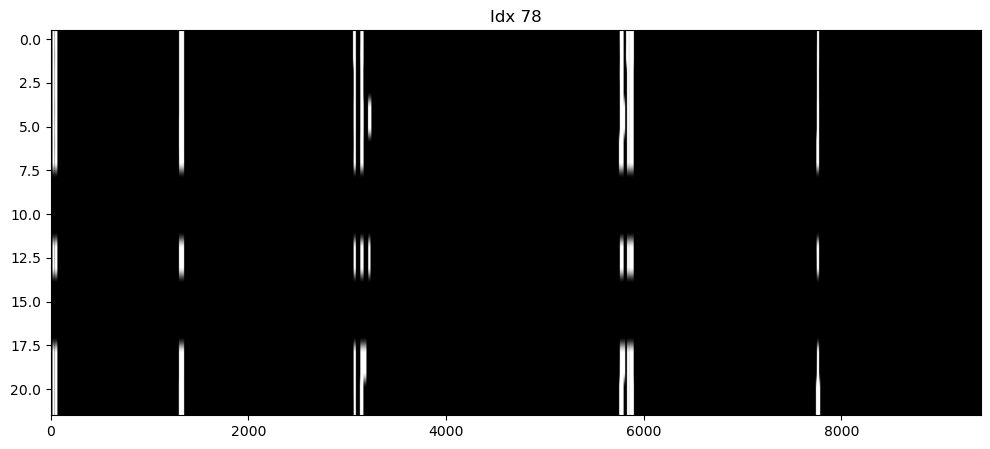

In [71]:
high_nans = np.where(m1_imp_rf_nan > np.quantile(m1_imp_rf_nan, .9))[0]
for idx in high_nans[:5]:
    fig, axs = plt.subplots(figsize = (12, 5))
    axs.imshow(np.where(np.isnan(m1_imp_rf_loc[idx]), 0, 1).T, aspect = "auto", cmap = "gray_r")
    axs.set_title(f"Idx {idx}")